# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (midi and music21) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added. If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python python3-midi/setup.py install` after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle

from functools import reduce
from random import randint
from bisect import bisect_left

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, model_from_json
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import midi
import music21

from collections import Counter

In [33]:
sciper = {'student_1': 284216, 
          'student_2': 285155}
seed = sciper['student_1']+sciper['student_2']

tmp_path = "tmp/"

%matplotlib inline

In [34]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):
    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    
    # Changed tick values
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=1, velocity=80, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t+1, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

In [35]:
def save_var(var, name):
    if not os.path.exists(os.path.dirname(tmp_path)):
        try:
            os.makedirs(os.path.dirname(tmp_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    with open(os.path.join(tmp_path, '{}.pckl'.format(name)), 'wb') as output_file:
        pickle.dump(var, output_file)

def load_var(name):
    if os.path.exists(tmp_path):
        with open(os.path.join(tmp_path, '{}.pckl'.format(name)), 'rb') as input_file:
            return pickle.load(input_file)
        return var
    else:
        return None

def save_model(model, name):
    model_json = model.to_json()
    with open(os.path.join(tmp_path, "{}.json".format(name)), "w") as json_file:
        json_file.write(model_json)
    model.save_weights(os.path.join(tmp_path, "{}.h5".format(name)))
    
def load_model(name):
    json_file = open(os.path.join(tmp_path, "{}.json".format(name)), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(os.path.join(tmp_path, "{}.h5".format(name)))
    return loaded_model

In [36]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [6]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.15:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

6962/45851 melodies retained


### Solution

In [7]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        if event.name == 'Note On':
            P.append(event.data[0])
        elif event.name == 'Note Off':
            T.append(event.tick + 1)
    return P, T

In [8]:
for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

In [9]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')

sessiontune13014
MIDI events
chorpus/sessiontune13014.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 77 	 Note On 	 105
720 	 77 	 Note Off 	 0
721 	 76 	 Note On 	 105
960 	 76 	 Note Off 	 0
961 	 77 	 Note On 	 80
1200 	 77 	 Note Off 	 0
1201 	 74 	 Note On 	 80
1440 	 74 	 Note Off 	 0
1441 	 74 	 Note On 	 95
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
45121 	 76 	 Note On 	 80
45360 	 76 	 Note Off 	 0
45361 	 72 	 Note On 	 105
46080 	 72 	 Note Off 	 0
46081 	 72 	 Note On 	 95
46560 	 72 	 Note Off 	 0
46561 	 79 	 Note On 	 80
46800 	 79 	 Note Off 	 0
########################################

Note representation
{'T': [720, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 720, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [10]:
reduce_union = lambda x, y: x.union(y)

def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError

In [11]:
def translation(dataset):
    durations = sorted(reduce(reduce_union, [set(dataset[x]['T']) for x in dataset]))
    pitches = sorted(reduce(reduce_union, [set(dataset[x]['P']) for x in dataset]))

    dur2Id = lambda x: index(durations, x)
    pit2Id = lambda x: index(pitches, x)
    dictionary = {'T': durations, 'P': pitches}

    for label in list(dataset.keys()):
        dataset[label]['T'] = list(map(dur2Id, dataset[label]['T']))
        dataset[label]['P'] = list(map(pit2Id, dataset[label]['P']))
    
    return dataset, dictionary
        
dataset, dictionary = translation(dataset)

In [12]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')

sessiontune27240
MIDI events
chorpus/sessiontune27240.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 68 	 Note On 	 105
240 	 68 	 Note Off 	 0
241 	 61 	 Note On 	 80
480 	 61 	 Note Off 	 0
481 	 65 	 Note On 	 80
720 	 65 	 Note Off 	 0
721 	 61 	 Note On 	 80
960 	 61 	 Note Off 	 0
961 	 65 	 Note On 	 95
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
59761 	 78 	 Note On 	 80
60000 	 78 	 Note Off 	 0
60001 	 77 	 Note On 	 80
60240 	 77 	 Note Off 	 0
60241 	 75 	 Note On 	 80
60480 	 75 	 Note Off 	 0
60481 	 73 	 Note On 	 95
61440 	 73 	 Note Off 	 0
########################################

Note representation
{'T': [26, 26, 26, 26, 26, 26, 26, 26, 38, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 38, 18, 18, 18, 26, 26, 38, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 38, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 38, 18, 18, 18, 26, 26, 38, 26, 26, 26, 26, 18, 18, 18, 26, 26, 26, 26, 38, 26, 2

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

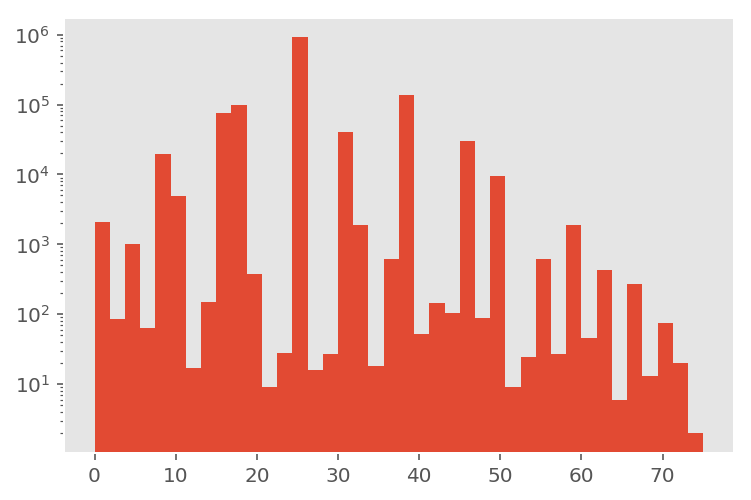

In [13]:
merged_durations = reduce(lambda x, y: x + y, [dataset[x]['T'] for x in dataset])

plt.hist(merged_durations, bins=40, log=True)
plt.show()

In [14]:
counts = Counter(x for x in merged_durations)
counts = Counter(dict(filter(lambda x: x[1] < 50, counts.items())))

cleaned_ds = {k: v for k, v in dataset.items() if len([i for i in counts.keys() if i in v['T']]) == 0}
print("Deleted {}% of elements".format(round((len(dataset) - len(cleaned_ds))/len(dataset),4) * 100))

Deleted 2.03% of elements


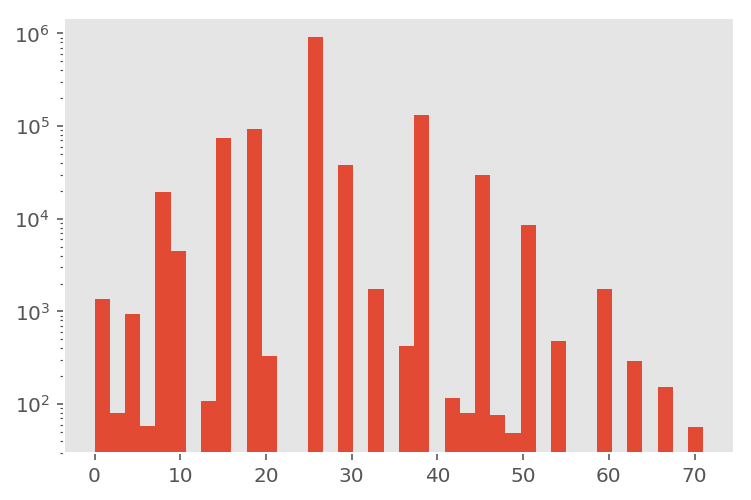

In [15]:
plt.hist(reduce(lambda x, y: x + y, [cleaned_ds[x]['T'] for x in cleaned_ds]), bins=40, log=True)
plt.show()

In [16]:
for label in np.random.choice(list(cleaned_ds.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')

sessiontune39980
MIDI events
chorpus/sessiontune39980.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 68 	 Note On 	 105
240 	 68 	 Note Off 	 0
241 	 61 	 Note On 	 80
480 	 61 	 Note Off 	 0
481 	 65 	 Note On 	 80
720 	 65 	 Note Off 	 0
721 	 61 	 Note On 	 80
960 	 61 	 Note Off 	 0
961 	 63 	 Note On 	 95
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
29041 	 77 	 Note On 	 80
29280 	 77 	 Note Off 	 0
29281 	 78 	 Note On 	 80
29520 	 78 	 Note Off 	 0
29521 	 75 	 Note On 	 80
29760 	 75 	 Note Off 	 0
29761 	 73 	 Note On 	 95
30480 	 73 	 Note Off 	 0
########################################

Note representation
{'T': [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 18, 18, 18, 26, 26, 26, 26, 26, 26, 26, 26, 45, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 18, 18, 18, 26, 26, 26, 26, 45, 26, 26, 26, 26, 26, 38, 26, 26, 26, 26, 26, 26, 38, 26, 2

In [17]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in log_progress(list(dataset.keys()), every=1):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [18]:
transposed_dataset = transposeDataset(cleaned_ds)

In [19]:
pitches = reduce(lambda x, y: x + y, [cleaned_ds[x]['P'] for x in cleaned_ds])
transposed_pitches = reduce(lambda x, y: x + y, [transposed_dataset[x]['P'] for x in transposed_dataset])

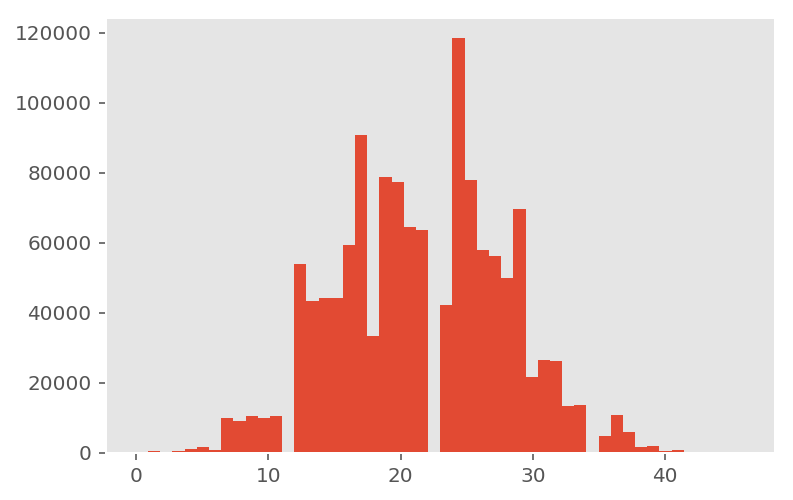

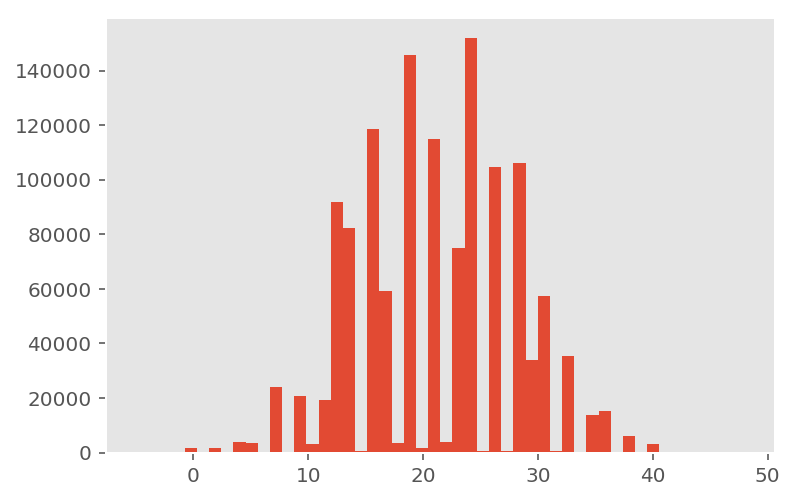

In [20]:
plt.hist(pitches, bins=50)
plt.show()

plt.hist(transposed_pitches, bins=50)
plt.show()

In [21]:
translated, dictionary = translation(transposed_dataset)

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: 

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**:

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: 

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: 

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [22]:
one_hot = {}
for label in list(translated.keys()):
    one_hot[label] = {}
    one_hot[label]['P'] = np_utils.to_categorical(translated[label]['P'], len(dictionary['P']))
    one_hot[label]['T'] = np_utils.to_categorical(translated[label]['T'], len(dictionary['T']))

In [23]:
lengths = np.array([x['P'].shape[0] for k, x in one_hot.items()])
ml = int(lengths.mean() + 2 * lengths.std())

ps = pad_sequences([x['P'] for k, x in one_hot.items()], maxlen=ml, padding='post', truncating='post')
ts = pad_sequences([x['T'] for k, x in one_hot.items()], maxlen=ml, padding='post', truncating='post')

dataset = {}
for i, label in enumerate(list(one_hot.keys())):
    dataset[label] = {}
    dataset[label]['P'] = ps[i]
    dataset[label]['T'] = ts[i]

sessiontune1460


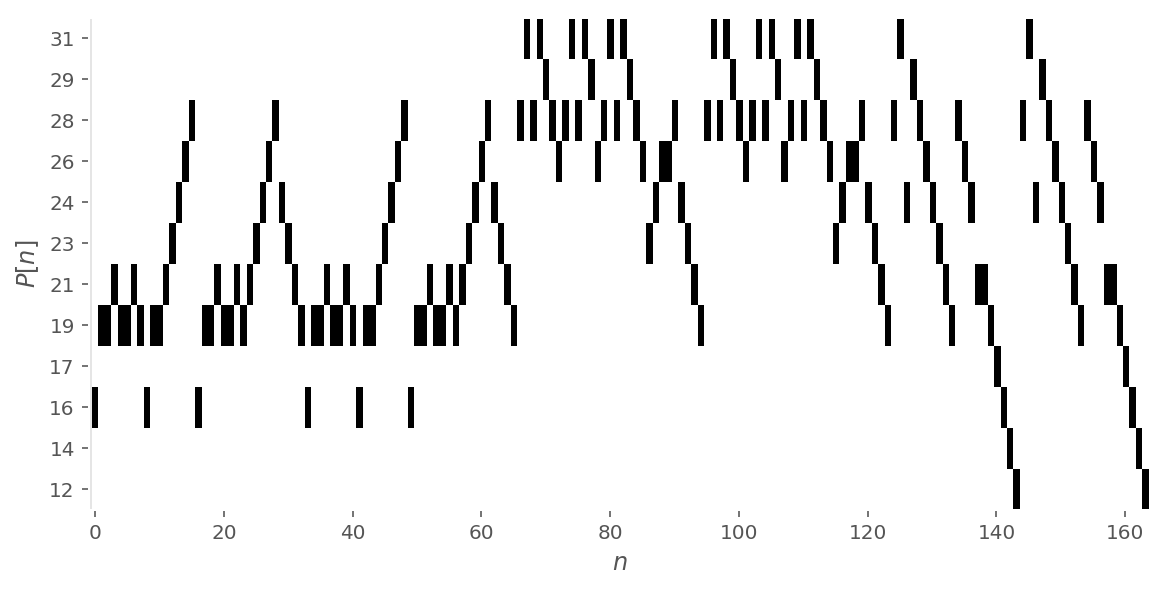

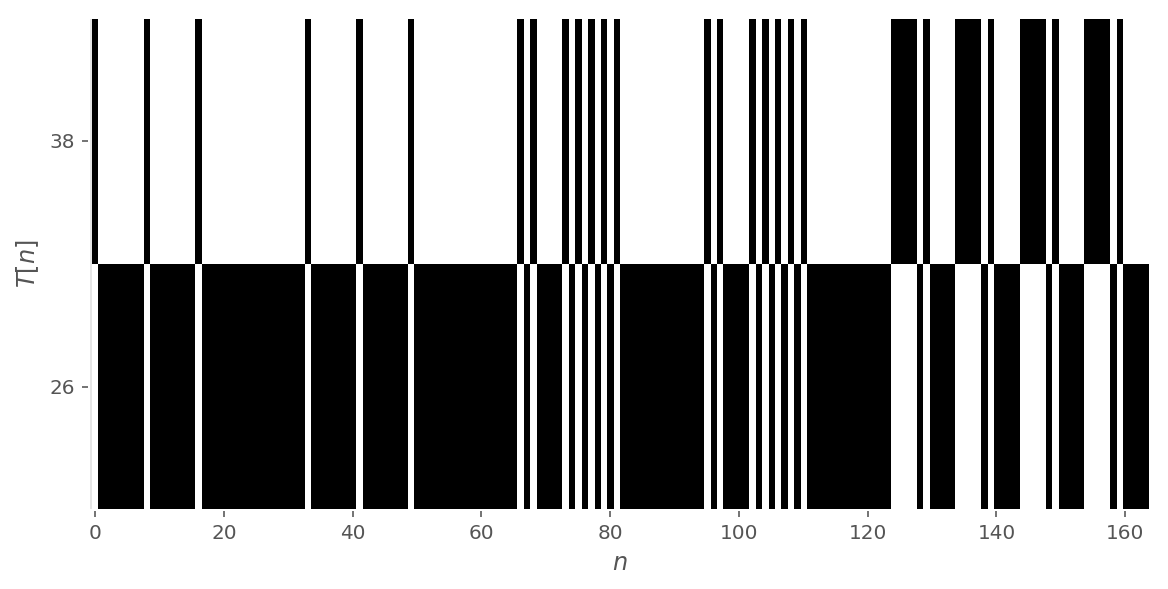

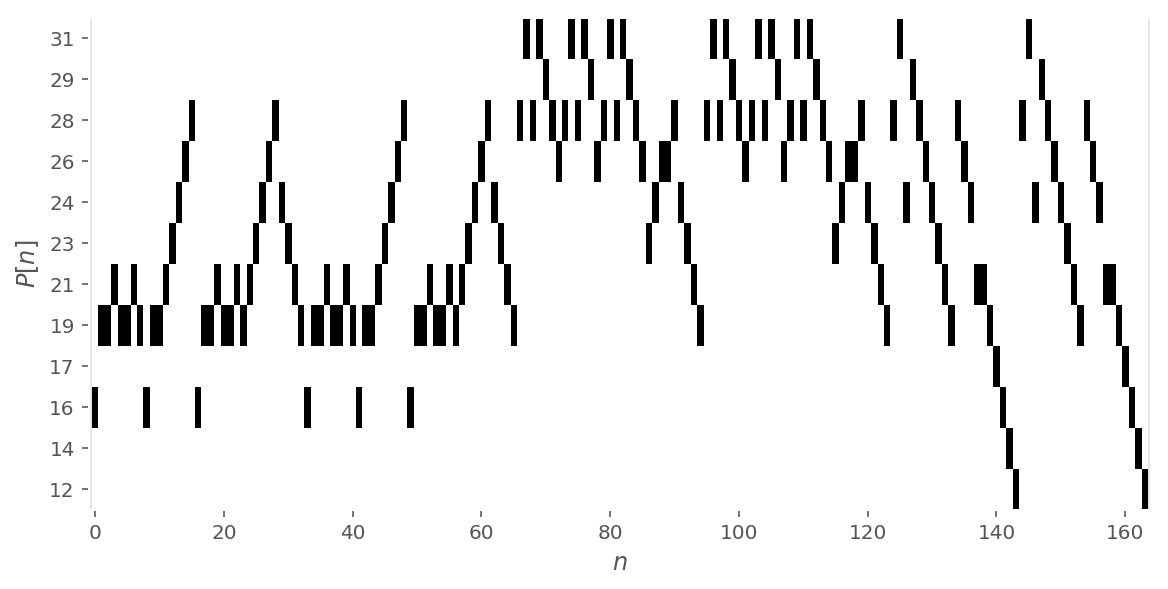

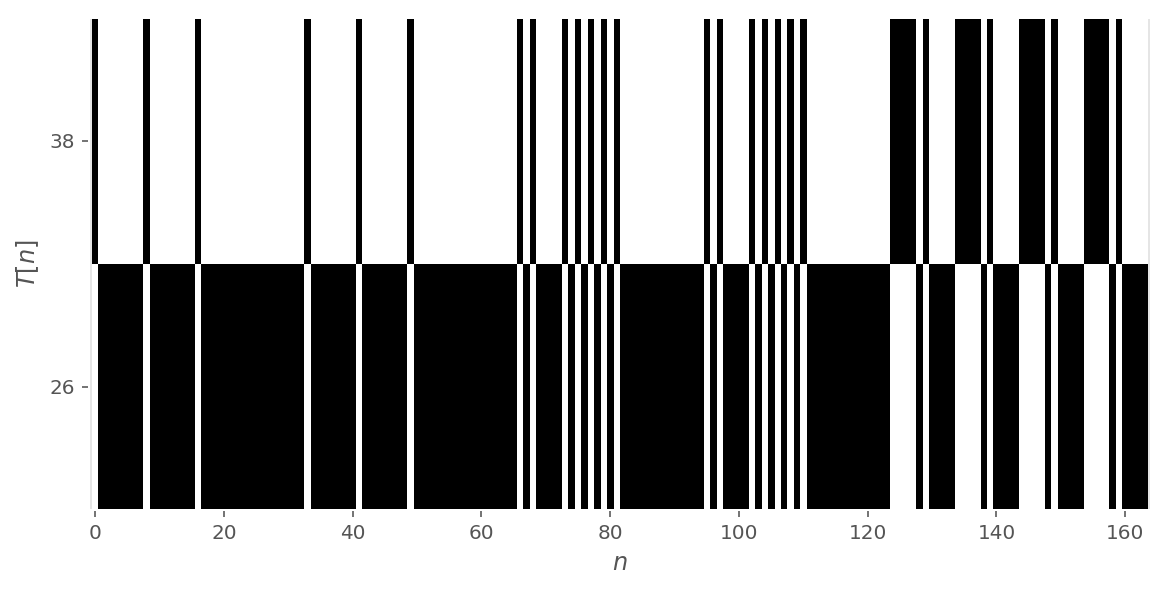

In [24]:
for label in np.random.choice(list(dataset.keys()), 1):
    print(label)
    plotMelody(dataset[label]['P'], dataset[label]['T'], dictionary)
    plotMelody(translated[label]['P'], translated[label]['T'], dictionary)

In [25]:
save_var(dataset, "dataset")
save_var(dictionary, "dictionary")
save_var(ml, "ml")

In [26]:
dataset = load_var("dataset")
dictionary = load_var("dictionary")
ml = load_var("ml")

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [27]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        H['2'] = GRU(units=128, return_sequences=True, dropout=dropout)(H['1'])
        H['3'] = GRU(units=256, return_sequences=True, dropout=dropout)(H['2'])
    elif activation == 'LSTM':
        pass
    elif activation == 'RNN':
        H['2'] = SimpleRNN(units=128, return_sequences=True, dropout=dropout)(H['1'])
        H['3'] = SimpleRNN(units=256, return_sequences=True, dropout=dropout)(H['2'])
        
    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['3'])
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['3'])
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    return model

In [28]:
GRUmodel = buildModel(dictionary, batch_length=ml-1, activation='GRU')
GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 388, 28)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 388, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 388, 28)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 388, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [29]:
RNNmodel = buildModel(dictionary, batch_length=ml-1, activation='RNN')
RNNmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 388, 28)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 388, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 388, 28)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 388, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [30]:
xs = {
    'XT': np.asarray([v['T'][:-1] for k, v in dataset.items()]), 
    'XP': np.asarray([v['P'][:-1] for k, v in dataset.items()])
}

ys = {
    'YT': np.asarray([v['T'][1:] for k, v in dataset.items()]), 
    'YP': np.asarray([v['P'][1:] for k, v in dataset.items()])
}

In [31]:
historyGRU = GRUmodel.fit(x=xs, y=ys, batch_size=ml-1, epochs=250, verbose=1, callbacks=None, validation_split=0.2)

Train on 5456 samples, validate on 1365 samples
Epoch 1/250
5456/5456 [==============================] - 116s 21ms/step - loss: 5.7003 - YT_loss: 2.1910 - YP_loss: 3.5093 - YT_acc: 0.6311 - YP_acc: 0.0861 - val_loss: 4.0876 - val_YT_loss: 1.1167 - val_YP_loss: 2.9709 - val_YT_acc: 0.6865 - val_YP_acc: 0.1196
Epoch 2/250
5456/5456 [==============================] - 112s 20ms/step - loss: 4.0434 - YT_loss: 1.1700 - YP_loss: 2.8734 - YT_acc: 0.6895 - YP_acc: 0.1376 - val_loss: 3.7928 - val_YT_loss: 1.0185 - val_YP_loss: 2.7743 - val_YT_acc: 0.6889 - val_YP_acc: 0.1369
Epoch 3/250
5456/5456 [==============================] - 110s 20ms/step - loss: 3.7294 - YT_loss: 1.0226 - YP_loss: 2.7068 - YT_acc: 0.7090 - YP_acc: 0.1599 - val_loss: 3.5111 - val_YT_loss: 0.9242 - val_YP_loss: 2.5869 - val_YT_acc: 0.7349 - val_YP_acc: 0.1823
Epoch 4/250
5456/5456 [==============================] - 112s 21ms/step - loss: 3.4640 - YT_loss: 0.9544 - YP_loss: 2.5097 - YT_acc: 0.7331 - YP_acc: 0.1811 - val_los

5456/5456 [==============================] - 107s 20ms/step - loss: 2.5781 - YT_loss: 0.6747 - YP_loss: 1.9034 - YT_acc: 0.7960 - YP_acc: 0.3321 - val_loss: 2.4469 - val_YT_loss: 0.6252 - val_YP_loss: 1.8217 - val_YT_acc: 0.8136 - val_YP_acc: 0.3621
Epoch 33/250
5456/5456 [==============================] - 110s 20ms/step - loss: 2.5718 - YT_loss: 0.6711 - YP_loss: 1.9007 - YT_acc: 0.7967 - YP_acc: 0.3325 - val_loss: 2.4392 - val_YT_loss: 0.6199 - val_YP_loss: 1.8194 - val_YT_acc: 0.8144 - val_YP_acc: 0.3648
Epoch 34/250
5456/5456 [==============================] - 112s 21ms/step - loss: 2.5556 - YT_loss: 0.6624 - YP_loss: 1.8932 - YT_acc: 0.7990 - YP_acc: 0.3356 - val_loss: 2.4352 - val_YT_loss: 0.6199 - val_YP_loss: 1.8153 - val_YT_acc: 0.8153 - val_YP_acc: 0.3645
Epoch 35/250
5456/5456 [==============================] - 110s 20ms/step - loss: 2.5565 - YT_loss: 0.6678 - YP_loss: 1.8887 - YT_acc: 0.7980 - YP_acc: 0.3371 - val_loss: 2.4283 - val_YT_loss: 0.6140 - val_YP_loss: 1.8143 - v

5456/5456 [==============================] - 109s 20ms/step - loss: 2.2508 - YT_loss: 0.5481 - YP_loss: 1.7026 - YT_acc: 0.8187 - YP_acc: 0.4050 - val_loss: 2.1409 - val_YT_loss: 0.5089 - val_YP_loss: 1.6320 - val_YT_acc: 0.8294 - val_YP_acc: 0.4328
Epoch 95/250
5456/5456 [==============================] - 107s 20ms/step - loss: 2.2507 - YT_loss: 0.5511 - YP_loss: 1.6997 - YT_acc: 0.8175 - YP_acc: 0.4061 - val_loss: 2.1394 - val_YT_loss: 0.5087 - val_YP_loss: 1.6307 - val_YT_acc: 0.8302 - val_YP_acc: 0.4338
Epoch 96/250
5456/5456 [==============================] - 112s 21ms/step - loss: 2.2410 - YT_loss: 0.5463 - YP_loss: 1.6947 - YT_acc: 0.8196 - YP_acc: 0.4091 - val_loss: 2.1345 - val_YT_loss: 0.5063 - val_YP_loss: 1.6282 - val_YT_acc: 0.8300 - val_YP_acc: 0.4359
Epoch 97/250
5456/5456 [==============================] - 113s 21ms/step - loss: 2.2399 - YT_loss: 0.5460 - YP_loss: 1.6940 - YT_acc: 0.8190 - YP_acc: 0.4086 - val_loss: 2.1304 - val_YT_loss: 0.5078 - val_YP_loss: 1.6227 - v

5456/5456 [==============================] - 112s 20ms/step - loss: 2.0780 - YT_loss: 0.5066 - YP_loss: 1.5714 - YT_acc: 0.8270 - YP_acc: 0.4530 - val_loss: 2.0165 - val_YT_loss: 0.4843 - val_YP_loss: 1.5323 - val_YT_acc: 0.8346 - val_YP_acc: 0.4680
Epoch 157/250
5456/5456 [==============================] - 110s 20ms/step - loss: 2.0985 - YT_loss: 0.5128 - YP_loss: 1.5857 - YT_acc: 0.8261 - YP_acc: 0.4474 - val_loss: 2.1032 - val_YT_loss: 0.5227 - val_YP_loss: 1.5805 - val_YT_acc: 0.8289 - val_YP_acc: 0.4517
Epoch 158/250
5456/5456 [==============================] - 111s 20ms/step - loss: 2.1594 - YT_loss: 0.5353 - YP_loss: 1.6242 - YT_acc: 0.8224 - YP_acc: 0.4331 - val_loss: 2.0541 - val_YT_loss: 0.4966 - val_YP_loss: 1.5575 - val_YT_acc: 0.8339 - val_YP_acc: 0.4589
Epoch 159/250
5456/5456 [==============================] - 111s 20ms/step - loss: 2.1133 - YT_loss: 0.5191 - YP_loss: 1.5942 - YT_acc: 0.8256 - YP_acc: 0.4440 - val_loss: 2.0314 - val_YT_loss: 0.4900 - val_YP_loss: 1.5414 

5456/5456 [==============================] - 109s 20ms/step - loss: 2.0259 - YT_loss: 0.5017 - YP_loss: 1.5243 - YT_acc: 0.8291 - YP_acc: 0.4690 - val_loss: 1.9811 - val_YT_loss: 0.4797 - val_YP_loss: 1.5014 - val_YT_acc: 0.8358 - val_YP_acc: 0.4800
Epoch 219/250
5456/5456 [==============================] - 108s 20ms/step - loss: 2.0014 - YT_loss: 0.4916 - YP_loss: 1.5099 - YT_acc: 0.8301 - YP_acc: 0.4751 - val_loss: 1.9674 - val_YT_loss: 0.4748 - val_YP_loss: 1.4926 - val_YT_acc: 0.8361 - val_YP_acc: 0.4841
Epoch 220/250
5456/5456 [==============================] - 108s 20ms/step - loss: 1.9947 - YT_loss: 0.4882 - YP_loss: 1.5065 - YT_acc: 0.8306 - YP_acc: 0.4772 - val_loss: 1.9652 - val_YT_loss: 0.4735 - val_YP_loss: 1.4917 - val_YT_acc: 0.8367 - val_YP_acc: 0.4832
Epoch 221/250
5456/5456 [==============================] - 109s 20ms/step - loss: 1.9876 - YT_loss: 0.4880 - YP_loss: 1.4996 - YT_acc: 0.8304 - YP_acc: 0.4790 - val_loss: 1.9590 - val_YT_loss: 0.4721 - val_YP_loss: 1.4868 

In [32]:
historyRNN = RNNmodel.fit(x=xs, y=ys, batch_size=ml-1, epochs=250, verbose=1, callbacks=None, validation_split=0.2)

Train on 5456 samples, validate on 1365 samples
Epoch 1/250
5456/5456 [==============================] - 60s 11ms/step - loss: 4.7143 - YT_loss: 1.5351 - YP_loss: 3.1793 - YT_acc: 0.6263 - YP_acc: 0.0882 - val_loss: 4.0032 - val_YT_loss: 1.1501 - val_YP_loss: 2.8531 - val_YT_acc: 0.6854 - val_YP_acc: 0.1068
Epoch 2/250
5456/5456 [==============================] - 58s 11ms/step - loss: 3.9030 - YT_loss: 1.0821 - YP_loss: 2.8208 - YT_acc: 0.6986 - YP_acc: 0.1222 - val_loss: 3.7209 - val_YT_loss: 0.9348 - val_YP_loss: 2.7861 - val_YT_acc: 0.7513 - val_YP_acc: 0.1203
Epoch 3/250
5456/5456 [==============================] - 59s 11ms/step - loss: 3.7085 - YT_loss: 0.9631 - YP_loss: 2.7454 - YT_acc: 0.7334 - YP_acc: 0.1465 - val_loss: 3.5240 - val_YT_loss: 0.8845 - val_YP_loss: 2.6394 - val_YT_acc: 0.7489 - val_YP_acc: 0.2057
Epoch 4/250
5456/5456 [==============================] - 58s 11ms/step - loss: 3.4837 - YT_loss: 0.9261 - YP_loss: 2.5576 - YT_acc: 0.7388 - YP_acc: 0.1825 - val_loss: 3

5456/5456 [==============================] - 57s 10ms/step - loss: 2.6036 - YT_loss: 0.6916 - YP_loss: 1.9120 - YT_acc: 0.7927 - YP_acc: 0.3286 - val_loss: 2.4085 - val_YT_loss: 0.6108 - val_YP_loss: 1.7977 - val_YT_acc: 0.8149 - val_YP_acc: 0.3705
Epoch 64/250
5456/5456 [==============================] - 60s 11ms/step - loss: 2.5950 - YT_loss: 0.6847 - YP_loss: 1.9102 - YT_acc: 0.7949 - YP_acc: 0.3291 - val_loss: 2.4170 - val_YT_loss: 0.6117 - val_YP_loss: 1.8054 - val_YT_acc: 0.8136 - val_YP_acc: 0.3686
Epoch 65/250
5456/5456 [==============================] - 57s 10ms/step - loss: 2.5892 - YT_loss: 0.6826 - YP_loss: 1.9066 - YT_acc: 0.7950 - YP_acc: 0.3308 - val_loss: 2.4044 - val_YT_loss: 0.6077 - val_YP_loss: 1.7967 - val_YT_acc: 0.8153 - val_YP_acc: 0.3701
Epoch 66/250
5456/5456 [==============================] - 62s 11ms/step - loss: 2.5907 - YT_loss: 0.6841 - YP_loss: 1.9067 - YT_acc: 0.7946 - YP_acc: 0.3310 - val_loss: 2.4191 - val_YT_loss: 0.6086 - val_YP_loss: 1.8105 - val_Y

5456/5456 [==============================] - 58s 11ms/step - loss: 2.5248 - YT_loss: 0.6576 - YP_loss: 1.8672 - YT_acc: 0.7989 - YP_acc: 0.3470 - val_loss: 2.3275 - val_YT_loss: 0.5756 - val_YP_loss: 1.7519 - val_YT_acc: 0.8202 - val_YP_acc: 0.3912
Epoch 126/250
5456/5456 [==============================] - 58s 11ms/step - loss: 2.5279 - YT_loss: 0.6624 - YP_loss: 1.8655 - YT_acc: 0.7978 - YP_acc: 0.3486 - val_loss: 2.3235 - val_YT_loss: 0.5810 - val_YP_loss: 1.7426 - val_YT_acc: 0.8212 - val_YP_acc: 0.3928
Epoch 127/250
5456/5456 [==============================] - 57s 10ms/step - loss: 2.5143 - YT_loss: 0.6534 - YP_loss: 1.8609 - YT_acc: 0.7999 - YP_acc: 0.3486 - val_loss: 2.3221 - val_YT_loss: 0.5783 - val_YP_loss: 1.7439 - val_YT_acc: 0.8211 - val_YP_acc: 0.3924
Epoch 128/250
5456/5456 [==============================] - 59s 11ms/step - loss: 2.5140 - YT_loss: 0.6480 - YP_loss: 1.8660 - YT_acc: 0.8025 - YP_acc: 0.3495 - val_loss: 2.3183 - val_YT_loss: 0.5740 - val_YP_loss: 1.7443 - va

5456/5456 [==============================] - 59s 11ms/step - loss: 2.4464 - YT_loss: 0.6323 - YP_loss: 1.8140 - YT_acc: 0.8039 - YP_acc: 0.3668 - val_loss: 2.2409 - val_YT_loss: 0.5419 - val_YP_loss: 1.6990 - val_YT_acc: 0.8258 - val_YP_acc: 0.4097
Epoch 188/250
5456/5456 [==============================] - 57s 11ms/step - loss: 2.4346 - YT_loss: 0.6201 - YP_loss: 1.8145 - YT_acc: 0.8051 - YP_acc: 0.3673 - val_loss: 2.2335 - val_YT_loss: 0.5409 - val_YP_loss: 1.6926 - val_YT_acc: 0.8261 - val_YP_acc: 0.4124
Epoch 189/250
5456/5456 [==============================] - 59s 11ms/step - loss: 2.4367 - YT_loss: 0.6259 - YP_loss: 1.8108 - YT_acc: 0.8043 - YP_acc: 0.3681 - val_loss: 2.2517 - val_YT_loss: 0.5534 - val_YP_loss: 1.6982 - val_YT_acc: 0.8237 - val_YP_acc: 0.4116
Epoch 190/250
5456/5456 [==============================] - 59s 11ms/step - loss: 2.4472 - YT_loss: 0.6299 - YP_loss: 1.8173 - YT_acc: 0.8044 - YP_acc: 0.3663 - val_loss: 2.2383 - val_YT_loss: 0.5449 - val_YP_loss: 1.6934 - va

5456/5456 [==============================] - 58s 11ms/step - loss: 2.4136 - YT_loss: 0.6234 - YP_loss: 1.7902 - YT_acc: 0.8048 - YP_acc: 0.3762 - val_loss: 2.2013 - val_YT_loss: 0.5376 - val_YP_loss: 1.6637 - val_YT_acc: 0.8279 - val_YP_acc: 0.4265
Epoch 250/250
5456/5456 [==============================] - 57s 10ms/step - loss: 2.4126 - YT_loss: 0.6220 - YP_loss: 1.7907 - YT_acc: 0.8047 - YP_acc: 0.3758 - val_loss: 2.2066 - val_YT_loss: 0.5396 - val_YP_loss: 1.6670 - val_YT_acc: 0.8272 - val_YP_acc: 0.4188


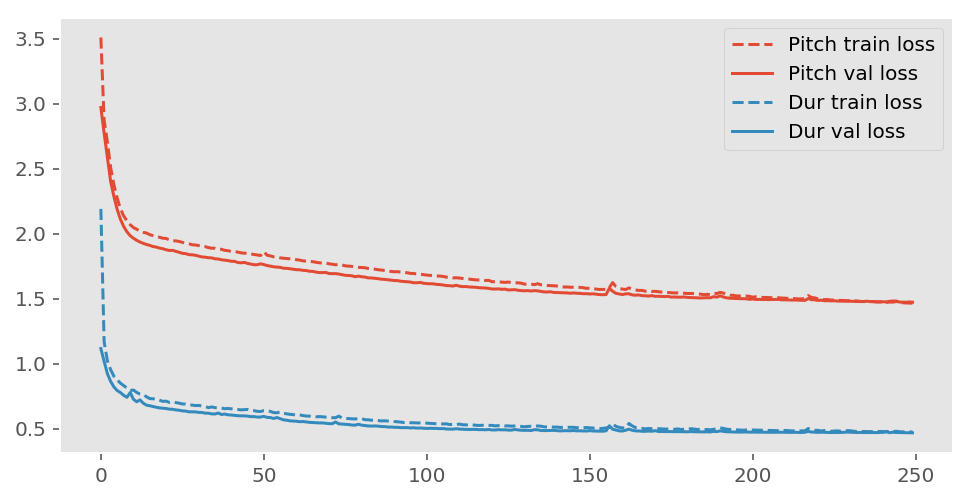

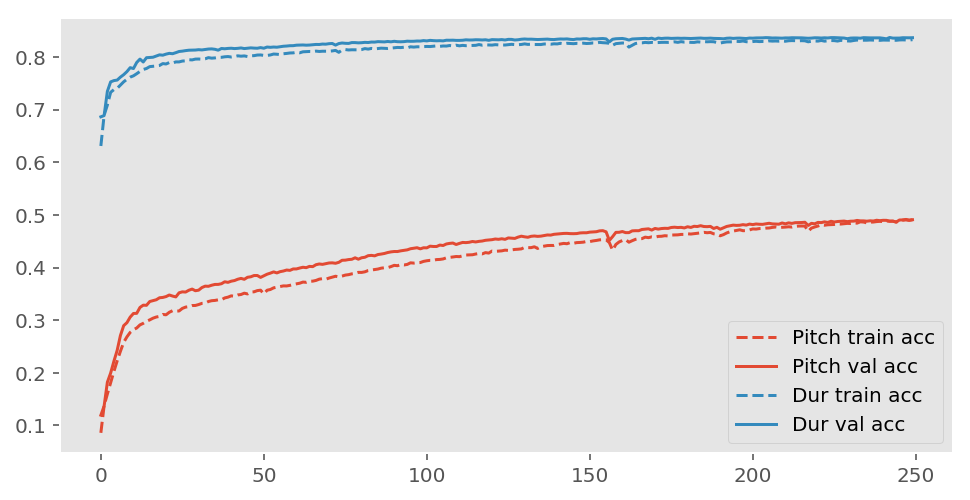

In [33]:
plotLearningCurves(historyGRU)

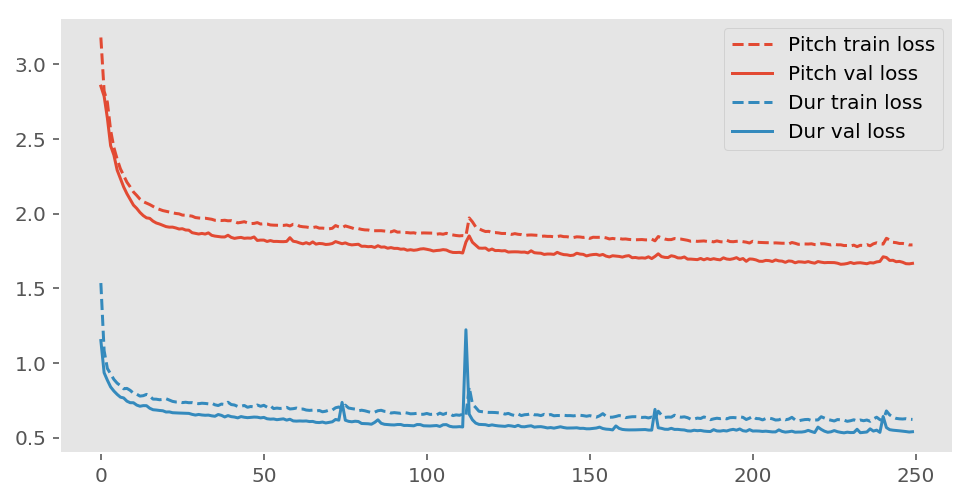

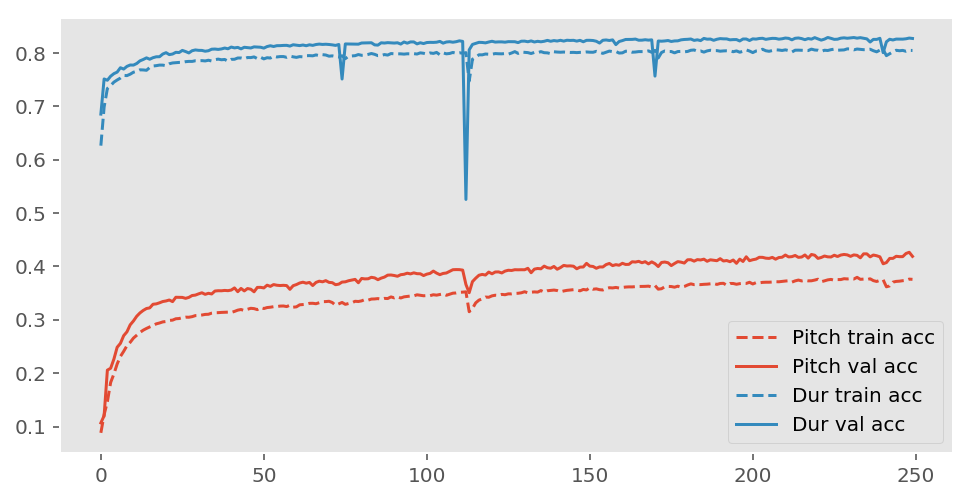

In [34]:
plotLearningCurves(historyRNN)

In [35]:
save_model(RNNmodel, "RNNmodel")
save_model(GRUmodel, "GRUmodel")

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: 



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

In [ ]:
RNNmodel = load_model("RNNmodel")
GRUmodel = load_model("GRUmodel")

In [36]:
get_intermediate_RNN = K.function([RNNmodel.layers[0].input, RNNmodel.layers[1].input],
                              [RNNmodel.layers[5].output, RNNmodel.layers[6].output])

get_intermediate_GRU = K.function([GRUmodel.layers[0].input, GRUmodel.layers[1].input],
                              [GRUmodel.layers[5].output, GRUmodel.layers[6].output])

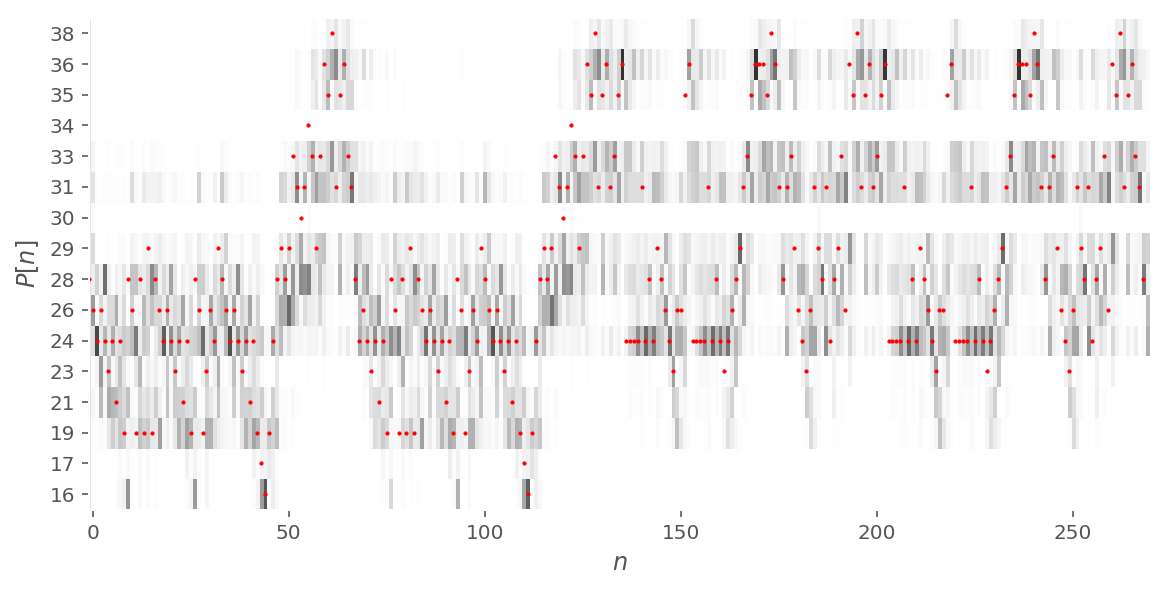

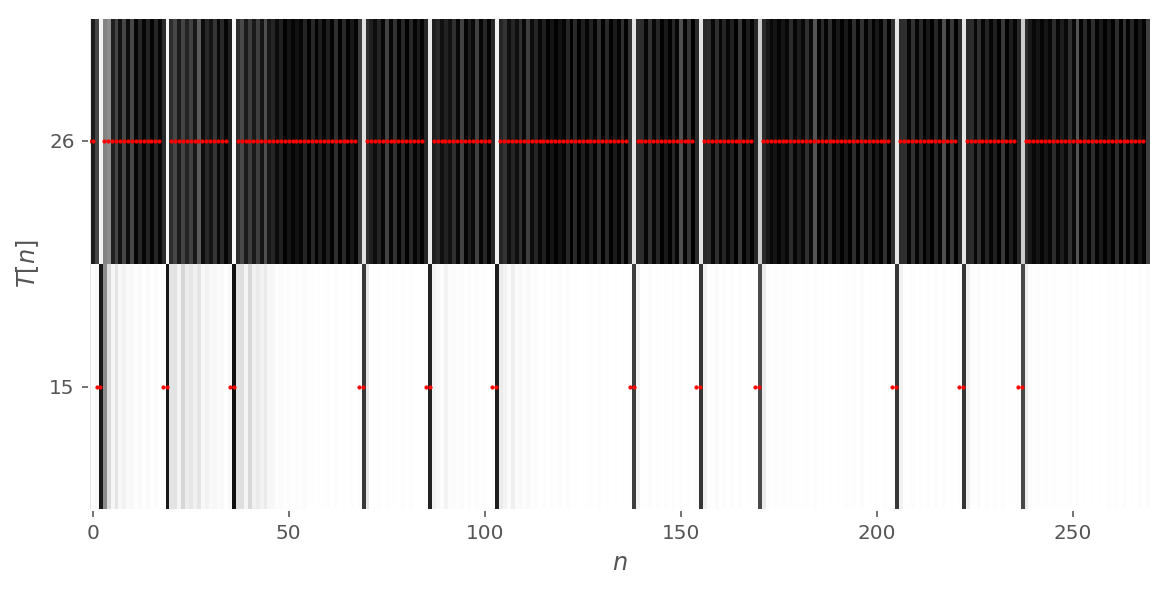

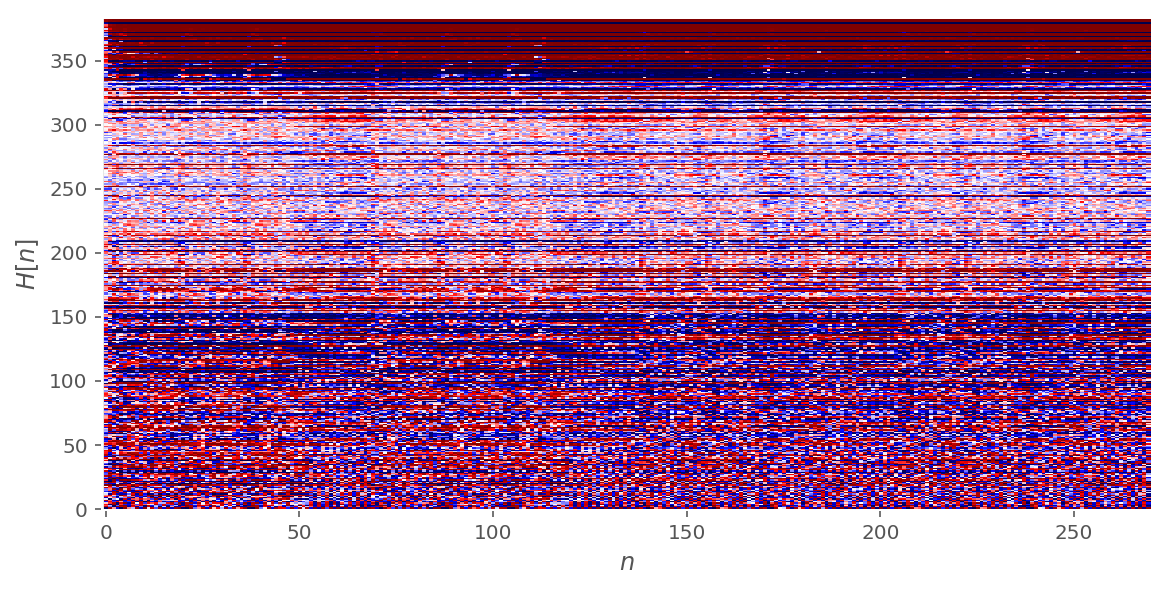

Accuracy: 'P': 8.89%, 'T': 0.0%


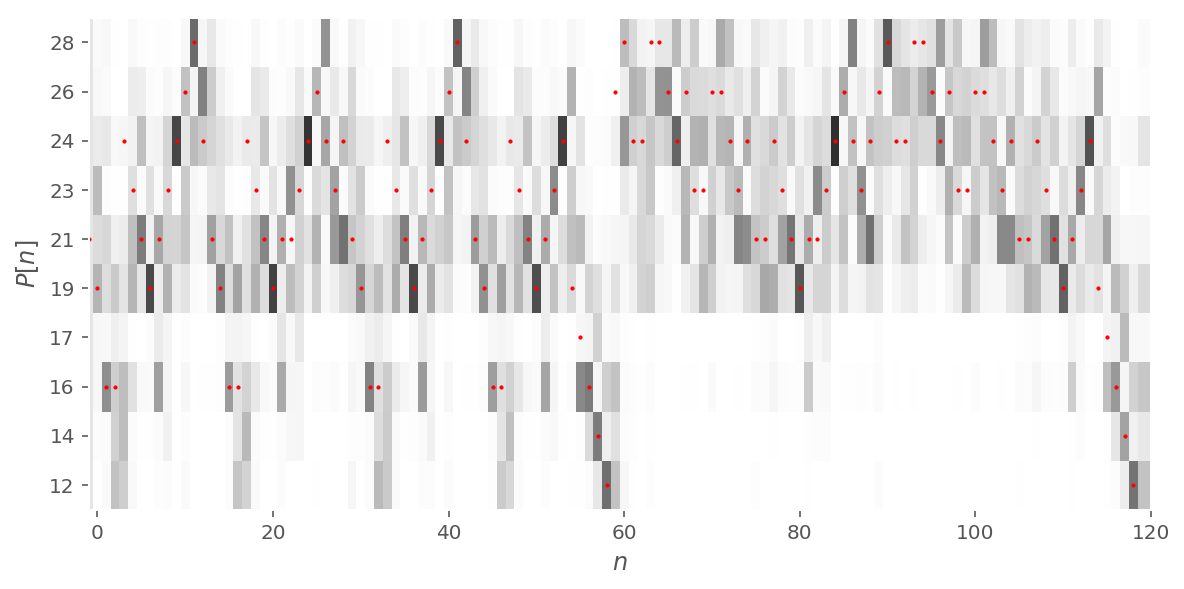

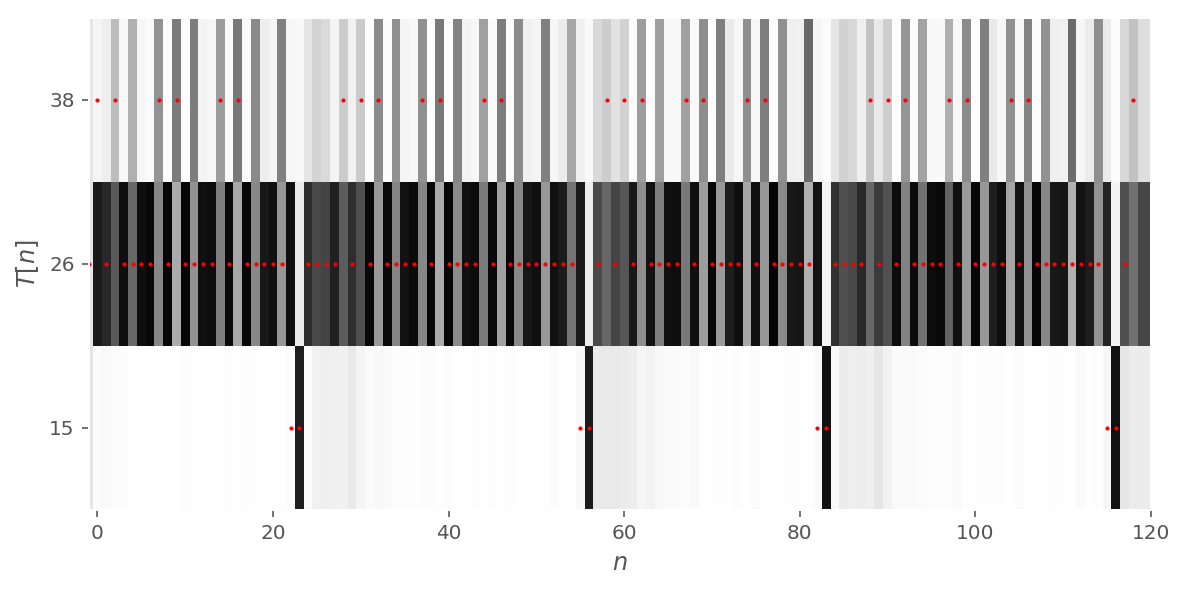

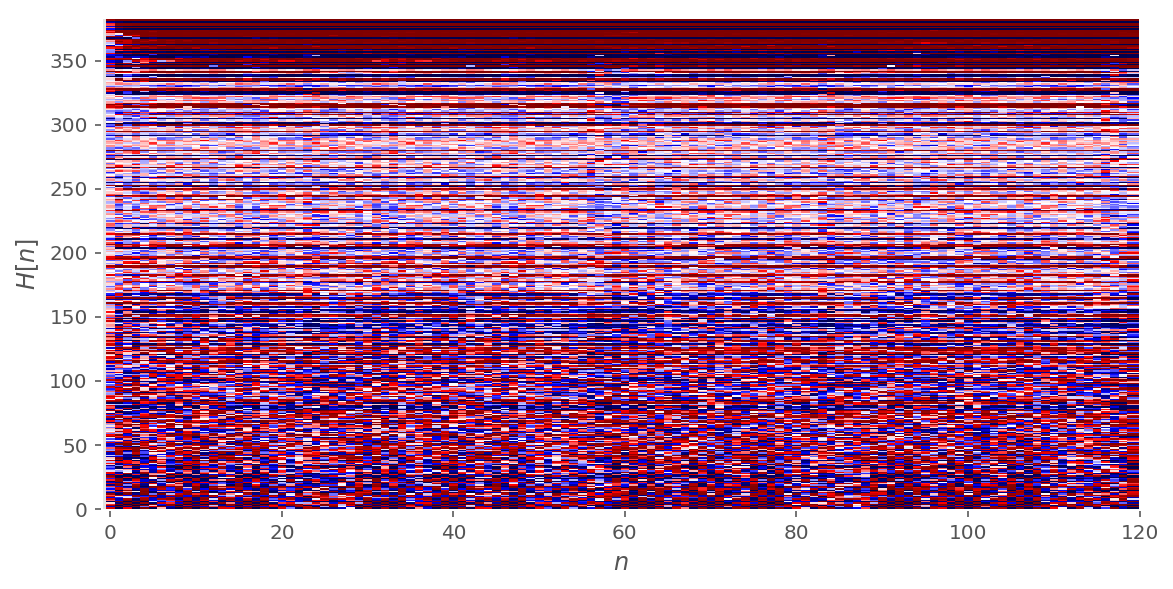

Accuracy: 'P': 5.0%, 'T': 0.0%


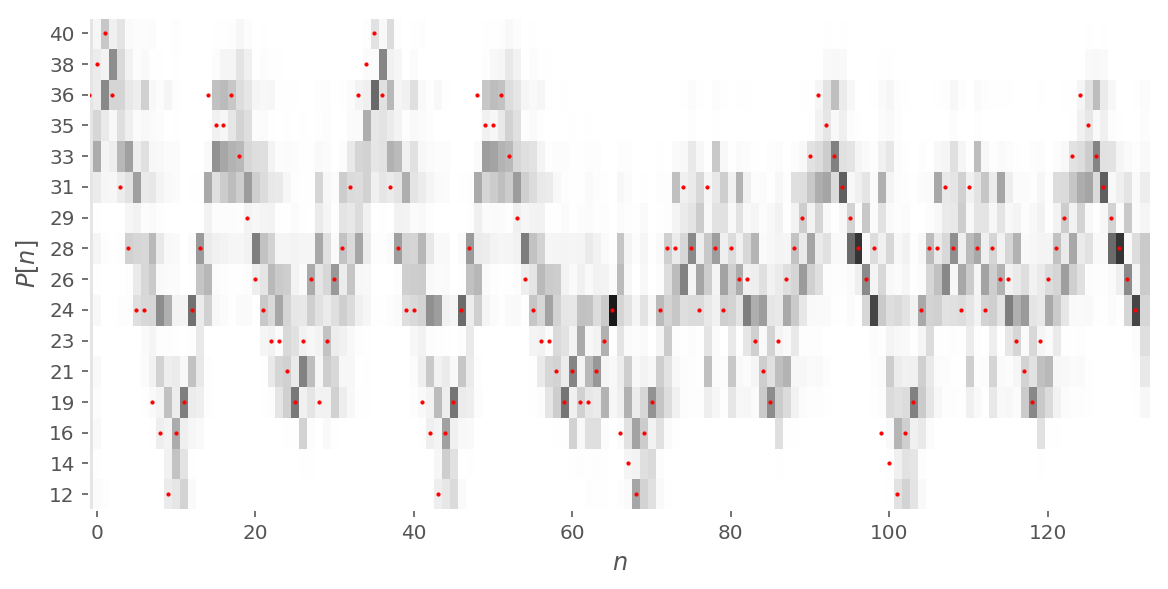

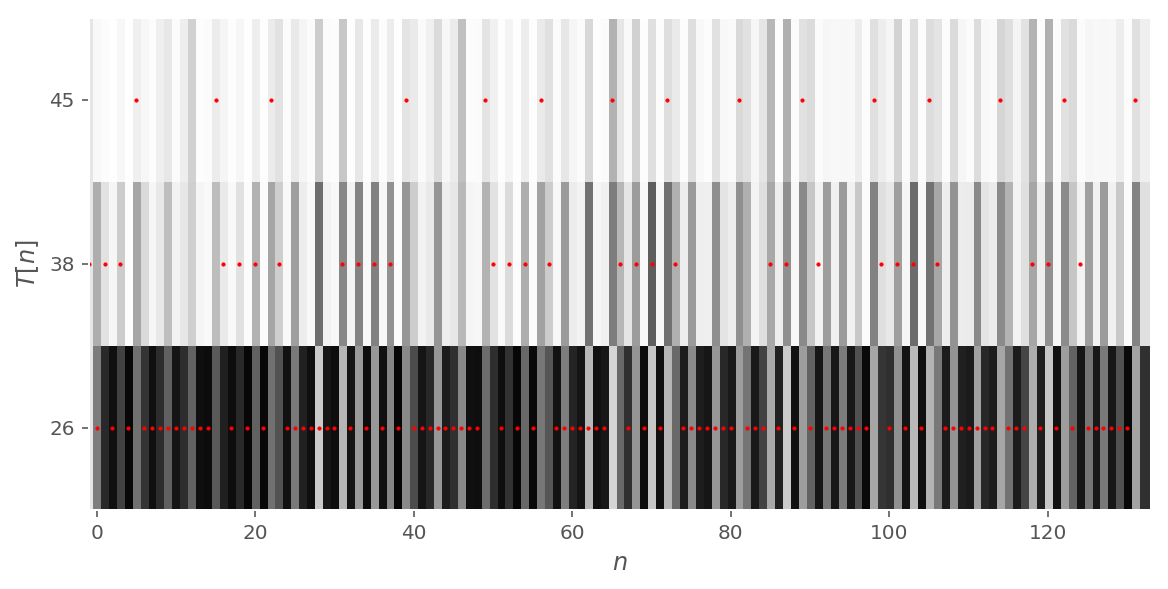

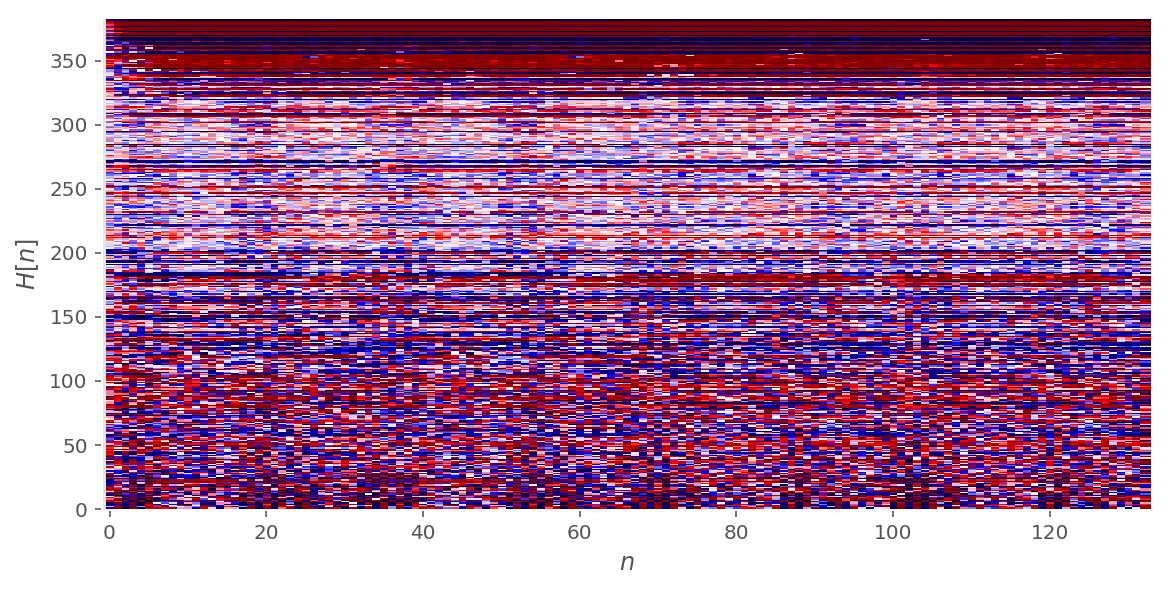

Accuracy: 'P': 0.0%, 'T': 0.0%


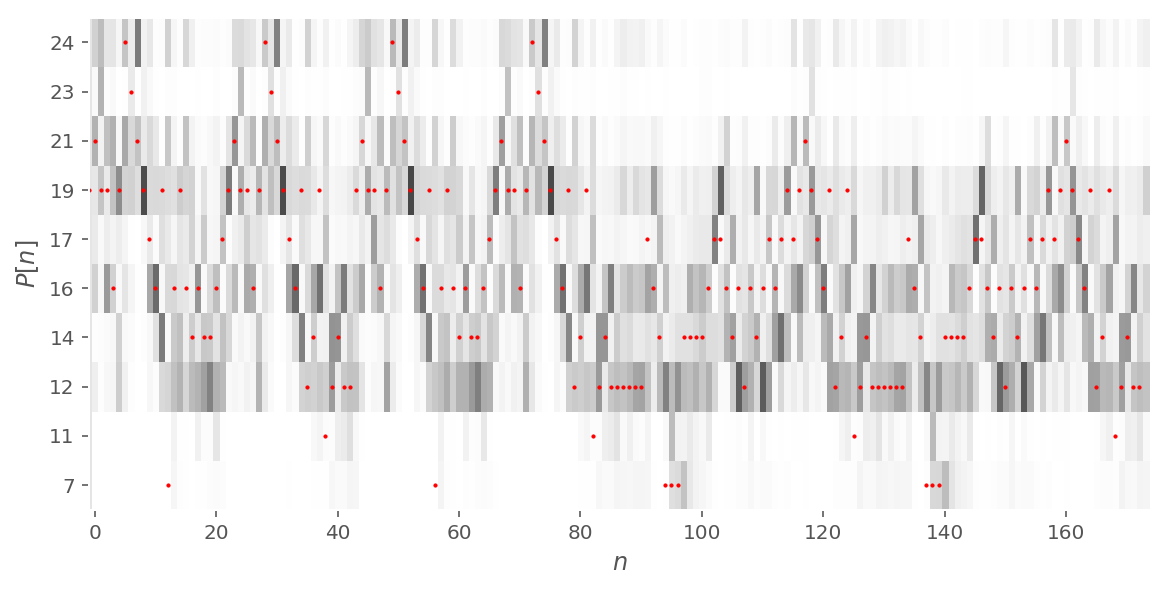

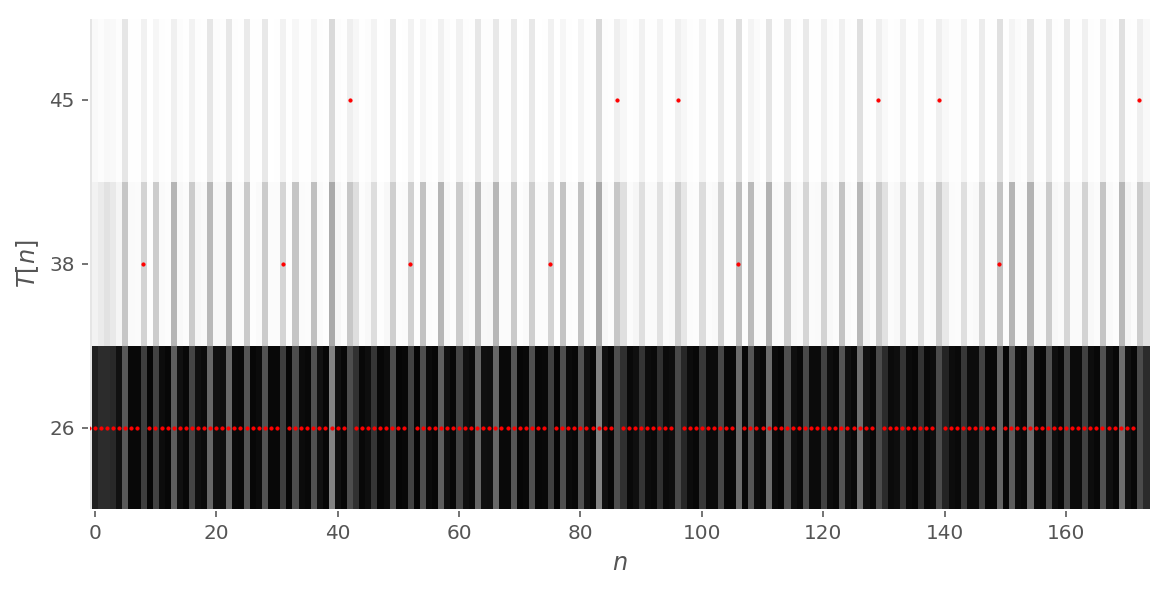

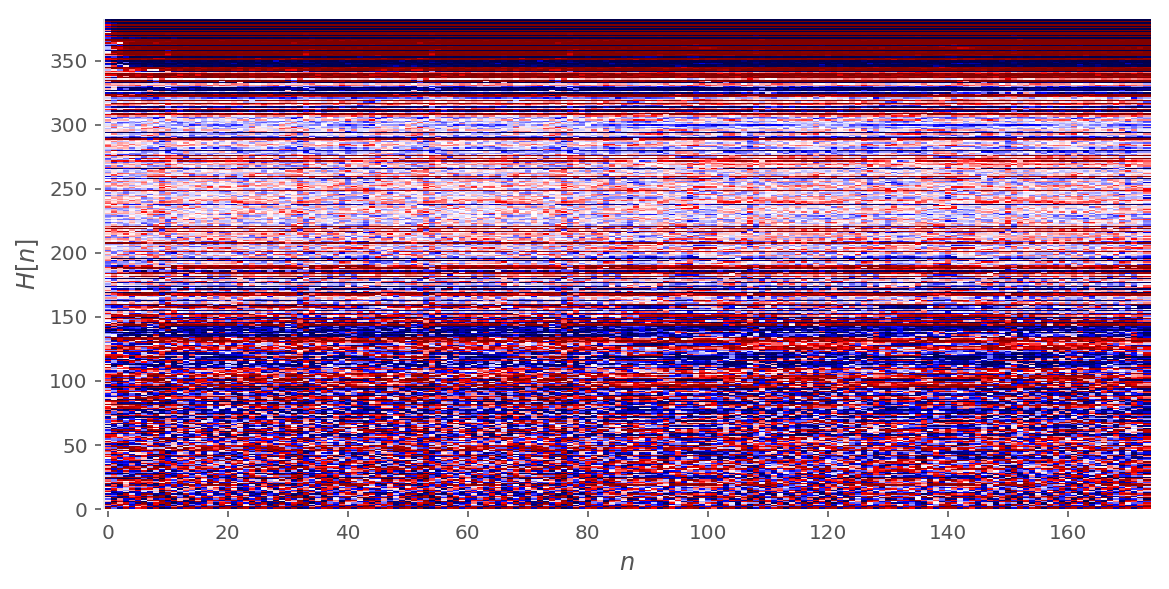

Accuracy: 'P': 10.92%, 'T': 0.0%


In [40]:
for label in np.random.choice(list(dataset.keys()), 4):
    
    dat = {
        'XT': np.expand_dims(dataset[label]['T'][:-1], axis=0),
        'XP': np.expand_dims(dataset[label]['P'][:-1], axis=0)
    }


    pred = RNNmodel.predict(dat, batch_size=ml-1)
    pred_2 = get_intermediate_RNN([dat['XT'], dat['XP']])

    t = pred[0].reshape((ml-1, len(dictionary['T'])))
    p = pred[1].reshape((ml-1, len(dictionary['P'])))
   
    t2 = pred_2[0].reshape((ml-1, 128))
    p2 = pred_2[1].reshape((ml-1, 256))
    
    H = np.hstack((t2,p2))

    accu_p = 0
    real_l_p = 0
    for i, e in enumerate(p):
        if 1 in dataset[label]['P'][i]:
            real_l_p +=1
            real_one = np.where(dataset[label]['P'][i] == 1)[0]
            one = np.where(e == np.max(e))[0][0]
            if real_one == one: 
                accu_p += 1

    accu_p = round(accu_p/real_l_p,4)*100

    accu_t = 0
    real_l_t = 0
    for i, e in enumerate(p):
        if 1 in dataset[label]['T'][i]:
            real_l_t +=1
            real_one = np.where(dataset[label]['T'][i] == 1)[0]
            one = np.where(e == np.max(e))[0][0]
            if real_one == one:
                accu_t += 1

    accu_t = round(accu_t/real_l_t,4)*100
    
    plotMelody(dataset[label]['P'], dataset[label]['T'], dictionary, PrP=p, PrT=t, H=H)
    print("Accuracy: 'P': {}%, 'T': {}%".format(accu_p, accu_t))

**CHANGES IN ACTIVATION**

In [41]:
delta_A_RNN = {
    'T':[],
    'P':[]
}

delta_A_GRU = {
    'T':[],
    'P':[]
}
for label in np.random.choice(list(dataset.keys()), 200):
    dat = {
        'XT': np.expand_dims(dataset[label]['T'][:-1], axis=0),
        'XP': np.expand_dims(dataset[label]['P'][:-1], axis=0)
    }
    #pred_1 = RNNmodel.predict(dat, batch_size=ml-1)
    pred_RNN = get_intermediate_RNN([dat['XT'], dat['XP']])

    delta_A_RNN['T'].append(np.mean(pred_RNN[0]))
    delta_A_RNN['P'].append(np.mean(pred_RNN[1]))
    
    #pred_2 = GRUModel.predict(dat, batch_size=ml-1)
    pred_GRU = get_intermediate_GRU([dat['XT'], dat['XP']])

    delta_A_GRU['T'].append(np.mean(pred_GRU[0]))
    delta_A_GRU['P'].append(np.mean(pred_GRU[1]))

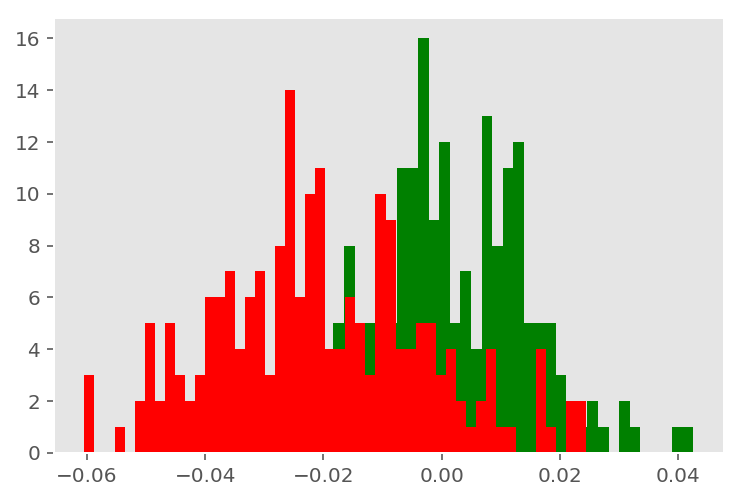

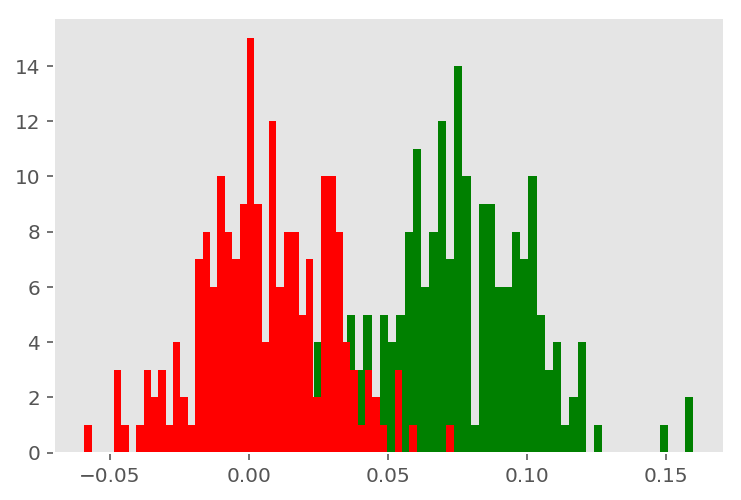

In [42]:
plt.hist(delta_A_RNN['T'], bins=50, color='g')
plt.hist(delta_A_GRU['T'], bins=50, color='r')
plt.show()

plt.hist(delta_A_RNN['P'], bins=50, color='g')
plt.hist(delta_A_GRU['P'], bins=50, color='r')
plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [43]:
if not os.path.exists(os.path.dirname("out/")):
    try:
        os.makedirs(os.path.dirname("out/"))
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise

def new_song(ini_p, ini_t, model,label):
    xp = np.zeros((ml-1, len(dictionary['P'])))
    xp[0][ini_p] = 1


    xt = np.zeros((ml-1, len(dictionary['T'])))
    xt[0][ini_t] = 1

    song = {
        'xT': [ini_t],
        'xP': [ini_p]
    }
    dat = {
        'XT': np.expand_dims(xt, axis=0),
        'XP': np.expand_dims(xp, axis=0)
    }
    
    for i in range(1, ml-1):
        next_note = model.predict(dat)
        next_note_t = next_note[0][0]
        next_note_p = next_note[1][0]
        #print('next_note_t:',next_note_t)

        t = sample(next_note_t[i-1])
        #print('t:',t)
        dat['XT'][0][i][t] = 1
        #print('dat[XT][0][i]:',dat['XT'][0][i])
        song['xT'].append(t)
        #print('song[xt]:',song['xT'])

        p = sample(next_note_p[i-1])
        dat['XP'][0][i][p] = 1
        song['xP'].append(p)

    writeMIDI(song['xP'], song['xT'], dictionary, 'out/{}.mid'.format(label))
    display('out/{}.mid'.format(label))

In [44]:
for i in range(32):
    t = randint(0,len(dictionary['T']))
    p = randint(0,len(dictionary['P']))
    label1 = 'GRU_{}'.format(i)
    new_song(p, t, GRUmodel, label1)
    label2 = 'RNN_{}'.format(i)
    new_song(p, t, RNNmodel, label2)

out/GRU_0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 33 	 Note On 	 80
16 	 33 	 Note Off 	 0
17 	 40 	 Note On 	 80
18 	 40 	 Note Off 	 0
19 	 21 	 Note On 	 80
46 	 21 	 Note Off 	 0
47 	 40 	 Note On 	 80
74 	 40 	 Note Off 	 0
75 	 21 	 Note On 	 80
102 	 21 	 Note Off 	 0
103 	 40 	 Note On 	 80
130 	 40 	 Note Off 	 0
131 	 38 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
10927 	 28 	 Note On 	 80
10954 	 28 	 Note Off 	 0
10955 	 21 	 Note On 	 80
10982 	 21 	 Note Off 	 0
10983 	 21 	 Note On 	 80
11010 	 21 	 Note Off 	 0
11011 	 21 	 Note On 	 80
11038 	 21 	 Note Off 	 0
########################################

out/RNN_0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 33 	 Note On 	 80
16 	 33 	 Note Off 	 0
17 	 35 	 Note On 	 80
18 	 35 	 Note Off 	 0
19 	 24 	 Note On 	 80
34 	 24 	 Note Off 	 0
3

ValueError: byte must be in range(0, 256)

In [ ]:
mf = music21.midi.MidiFile()
mf.open('GRU_1.mid')
mf.read()
mf.close()
s = music21.midi.translate.midiFileToStream(mf)
print('GRU')
s.show('midi')

In [ ]:
mf = music21.midi.MidiFile()
mf.open('RNN_1.mid')
mf.read()
mf.close()
s = music21.midi.translate.midiFileToStream(mf)
print('RNN')
s.show('midi')

**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: 

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: 

